In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('ggplot')
import seaborn as sns
import statistics

In [30]:
results = pd.read_csv("test_results/pg_duck_tpch_scaling_test_results.csv") 
test_name = "postgres_duck_db_scaling"

results = results.rename(columns={"Average": "Mean"})

In [31]:
print(len(results))
results.head()

264


,Data Type,Scaling Factor,Query Name,Query Number,Mean,Correct,Executed,Runs
0,SQL,1,Postgres,Query 1,6.010,True,Yes,"[5.971983909606934, 5.659321069717407, 5.90975..."
1,SQL,1,Duck DB,Query 1,0.454,True,Yes,"[0.44919443130493164, 0.43576788902282715, 0.4..."
2,Pandas,1,Pandas Converted (Duck DB),Query 1,1.400,True,Yes,"[1.8382604122161865, 1.316760778427124, 1.2993..."
3,Pandas,1,Pandas Converted (Postgres),Query 1,1.650,True,Yes,"[2.179121971130371, 1.5935218334197998, 1.6101..."
4,SQL,1,Postgres,Query 2,1.190,True,Yes,"[1.3112611770629883, 1.133206844329834, 1.1428..."


In [32]:
# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(len(results))

264


In [33]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

results['Median'] = results.apply(lambda row: statistics.median(sorted(row['Runs'])), axis = 1)

def ignore_first_mean(runs):
    return statistics.mean(runs[1:])

results['Mean_first'] = results.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
results["Query Type"] = results["Query Name"]

In [34]:
scaling_results = results \
    .groupby(['Scaling Factor', 'Query Type'], sort=False, as_index=False) \
    .agg(
        mean_runtime=("Mean_first", "mean"),
    )

scaling_results = scaling_results.sort_values(by=["Scaling Factor", "Query Type"])

In [35]:
scaling_results

,Scaling Factor,Query Type,mean_runtime
10,1,Duck DB,0.361325
9,1,Pandas Converted (Duck DB),1.180460
8,1,Pandas Converted (Postgres),1.799108
0,1,Postgres,2.553410
5,2,Duck DB,0.791060
6,2,Pandas Converted (Duck DB),2.675514
11,2,Pandas Converted (Postgres),4.019238
7,2,Postgres,5.363583
3,4,Duck DB,1.978765
2,4,Pandas Converted (Duck DB),6.928626


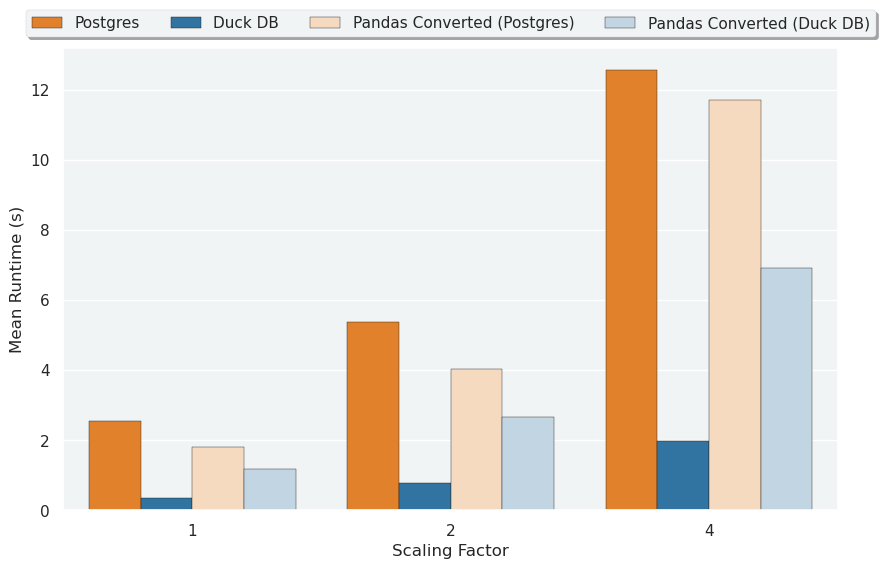

In [38]:
# plot with seaborn barplot
sns.set(rc={'figure.figsize':(10,6)})
background_color = '#f1f4f5'
sns.set(rc={'axes.facecolor':background_color})
plt.rcParams['patch.linewidth'] = 0.3
plt.rcParams['patch.edgecolor'] = 'k'

color = ['tab:orange','tab:blue','#ffd9b7', '#bcd6e9']
order = ["Postgres", "Duck DB", "Pandas Converted (Postgres)", "Pandas Converted (Duck DB)"]

ax = sns.barplot(data=scaling_results, x='Scaling Factor', y='mean_runtime', hue='Query Type',
                 palette=color, hue_order=order)

ax.set(xlabel='Scaling Factor', ylabel='Mean Runtime (s)')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
           ncol=4, fancybox=True, shadow=True)

plt.savefig("analysis_results/" + str(test_name) + "_queries.pdf", bbox_inches="tight")
plt.show()